In [1]:
#mount google drive when on google colab and set working directory

import sys
import os

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/music_speech/')

working_dir = os.getcwd()
print(f'\nWorking directory: {working_dir}')


Working directory: /Users/kraehenb/music_speech


In [2]:
#check working directory and repo (git clone git@github.com:jkcas22/music_speech.git)

!{sys.executable} -m pip install gitpython
import git

repo = ['git@github.com:jkcas22/music_speech.git', 'https://github.com/jkcas22/music_speech.git']

if git.Repo(working_dir).remotes.origin.url in repo:
    print(f'\nRepository and working directory are fine.')
else:
    print(f'\nRepository: {git.Repo(working_dir).remotes.origin.url}')


Repository and working directory are fine.


In [3]:
#initialize environment, load modules/libraries

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

#import python code from seperate files
from helpers.fourier_transform import load_wav, dft_logmag, patches

2023-02-26 22:29:42.829419: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
music_dir = './data/music_wav'
if not os.path.isdir(music_dir): 
    print(f'copy folder "music_wav" from unzipped 34.tar to {os.path.join(working_dir, "data","")}')

music_test = [
    'unpoco.wav',
    'blues.wav',
    'gismonti.wav',
    'ipanema.wav',
    'deedee.wav',
    'hendrix.wav',
    'madradeus.wav',
    'marlene.wav',
    'beatles.wav',
    'bagpipe.wav',
    'redhot.wav',
    'jazz.wav'
]
music_test = [os.path.join(music_dir, file) for file in music_test]

music = [os.path.join(music_dir, file) for file in os.listdir(music_dir) if file.endswith('.wav')]
music = list(set(music)-set(music_test))

speech_dir = './data/speech_wav'
if not os.path.isdir(speech_dir): 
    print(f'copy folder "speech_wav" from unzipped 34.tar to {os.path.join(working_dir, "data","")}')

speech_test = [
    'comedy.wav',
    'thlui.wav',
    'voices.wav',
    'conversion.wav',
    'china.wav',
    'vegetables2.wav',
    'amal.wav',
    'teachers2.wav',
    'chant.wav',
    'pulp2.wav',
    'acomic.wav',
    'kid.wav'
]
speech_test = [os.path.join(speech_dir, file) for file in speech_test]

speech = [os.path.join(speech_dir, file) for file in os.listdir(speech_dir) if file.endswith('.wav')]
speech = list(set(speech)-set(speech_test))

In [5]:
test = speech_test + music_test
test_labels = np.zeros(len(test))
test_labels[0:len(speech_test)]=1

split = len(speech)*8//10

train = speech[:split] + music[:split]
train_labels = np.zeros(len(train))
train_labels[:split]=1

validate = speech[split:] + music[split:]
validate_labels = np.zeros(len(validate))
validate_labels[:len(speech[split:])]=1

def permute(data, labels):
    p = list(zip(data,labels))
    random.shuffle(p)
    data, labels = zip(*p)
    return data, labels

test, test_labels = permute(test, test_labels)
train, train_labels = permute(train, train_labels)
validate, validate_labels = permute(validate, validate_labels)

print("Number of sounds (music and speech)")
print(f"- Test: {len(test)}")
print(f"- Validation: {len(validate)}")
print(f"- Training: {len(train)}")

Number of sounds (music and speech)
- Test: 24
- Validation: 22
- Training: 82


In [6]:
test_sounds = load_wav(test)
train_sounds = load_wav(train)
validate_sounds = load_wav(validate)

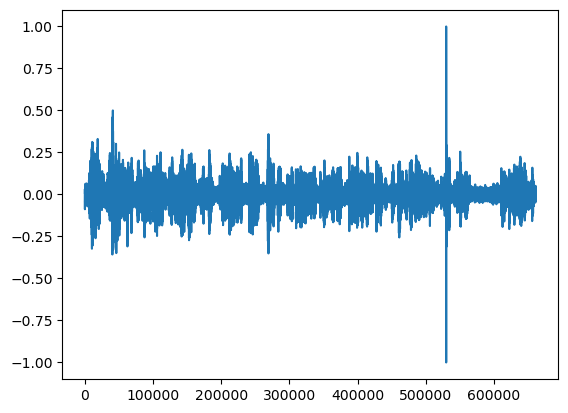

In [7]:
plt.plot(train_sounds[0])
plt.show()

In [8]:
fft_step=256
fft_size=512
fft_chunks = len(train_sounds[0])//fft_step

test_logmag = dft_logmag(test_sounds,fft_chunks,fft_step,fft_size)
train_logmag = dft_logmag(train_sounds,fft_chunks,fft_step,fft_size)
validate_logmag = dft_logmag(validate_sounds,fft_chunks,fft_step,fft_size)

print("logmag shape")
print(f"- Test: {test_logmag.shape}")
print(f"- Validation: {validate_logmag.shape}")
print(f"- Training: {train_logmag.shape}")

logmag shape
- Test: (24, 2583, 256)
- Validation: (22, 2583, 256)
- Training: (82, 2583, 256)


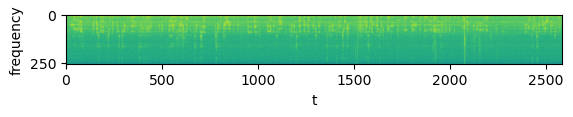

In [9]:
plt.imshow(train_logmag[0].T)
plt.xlabel('t')
plt.ylabel('frequency')
plt.show()

In [10]:
patch_step = 1
patch_size = 20

n_timesteps, n_feature = train_logmag[0].shape

def ds_window(sound, label):
    # labels = np.array(range(len(sound)))
    # sound = np.c_[sound,labels]
    labels = np.ones(n_timesteps)*label
    sound = np.c_[sound,labels]
    #ds = tf.expand_dims(sound, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(sound)
    ds = ds.window(size=patch_size,shift=patch_step,drop_remainder=True)
    return ds

def ds_patches(sounds, labels):
    ds = ds_window(sounds[0],labels[0])
    for sound, label in zip(sounds[1:],labels[1:]): ds = ds.concatenate(ds_window(sound,label))
    ds = ds.flat_map(lambda x: x.batch(patch_size))
    ds = ds.map(lambda x: (x[:patch_size,:-1], x[0,-1]))
    return ds.batch(1)

test_ds = ds_patches(test_logmag, test_labels)
train_ds = ds_patches(train_logmag, train_labels)
validate_ds = ds_patches(validate_logmag, validate_labels)

n_chunks = ((test_logmag.shape[1]-patch_size)//patch_step)+1
n_test = test_logmag.shape[0]*n_chunks
n_train = train_logmag.shape[0]*n_chunks
n_validate = validate_logmag.shape[0]*n_chunks

print(f"{train_ds}\n")
print("Total number of chunks")
print(f"- Test: {n_test}")
print(f"- Validation: {n_validate}")
print(f"- Training: {n_train}")


2023-02-26 22:30:30.689530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<BatchDataset element_spec=(TensorSpec(shape=(None, None, 256), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

Total number of chunks
- Test: 61536
- Validation: 56408
- Training: 210248


In [11]:
for sound, label in train_ds.take(1):
    print(sound.numpy().shape)
    print(label.numpy().shape)

(1, 20, 256)
(1,)


In [12]:
n = 10
for sound, label in train_ds.take(n):
    sound = sound.numpy()[0]
    print(f"{sound.shape} : {sound[[0,patch_step],0]} : {sound[[-patch_step-1,-1],0]}")

(20, 256) : [-7.20707823 -7.48226482] : [-5.91540087 -4.03263323]
(20, 256) : [-7.48226482 -4.99213584] : [-4.03263323 -4.30401384]
(20, 256) : [-4.99213584 -4.4867679 ] : [-4.30401384 -5.61927433]
(20, 256) : [-4.4867679  -5.41463321] : [-5.61927433 -5.45861068]
(20, 256) : [-5.41463321 -4.69596029] : [-5.45861068 -3.16685885]
(20, 256) : [-4.69596029 -5.11090796] : [-3.16685885 -4.50458696]
(20, 256) : [-5.11090796 -5.21583583] : [-4.50458696 -4.18969515]
(20, 256) : [-5.21583583 -6.70416742] : [-4.18969515 -6.20459474]
(20, 256) : [-6.70416742 -5.01685687] : [-6.20459474 -3.61762033]
(20, 256) : [-5.01685687 -7.73395907] : [-3.61762033 -5.04431758]


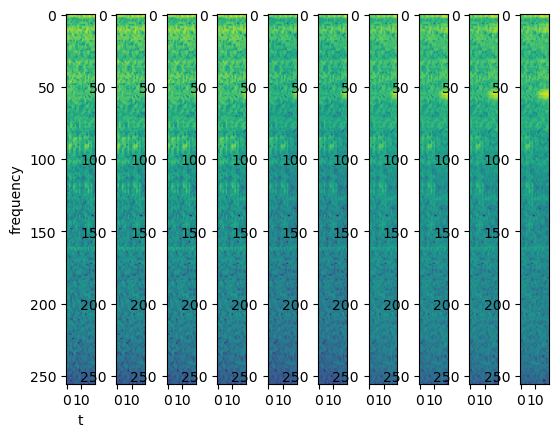

In [13]:
for i, (sound, label) in enumerate(train_ds.take(n)):
    plt.subplot(1,n,i+1)
    plt.imshow(sound.numpy()[0].T)
    if i == 0:
        plt.xlabel('t')
        plt.ylabel('frequency')
plt.show()

In [14]:
train_ds = train_ds.shuffle(5*n_chunks).prefetch(1)
validate_ds = validate_ds.shuffle(5*n_chunks).prefetch(1)
test_ds = test_ds.shuffle(5*n_chunks).prefetch(1)


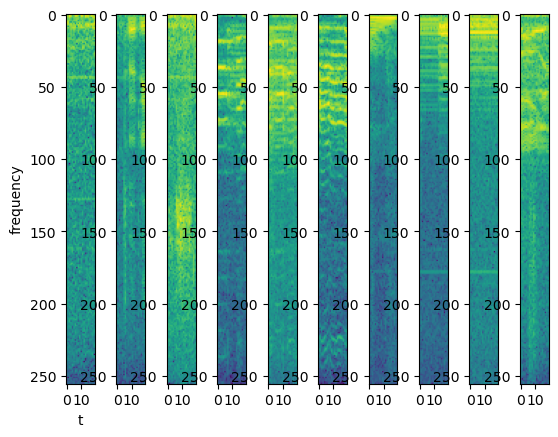

In [15]:
for i, (sound, label) in enumerate(train_ds.take(n)):
    plt.subplot(1,n,i+1)
    plt.imshow(sound.numpy()[0].T)
    if i == 0:
        plt.xlabel('t')
        plt.ylabel('frequency')
plt.show()

In [16]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(512,return_sequences=True, activation='relu', input_shape=(patch_size,n_feature)))
#model.add(tf.keras.layers.LSTM(256,return_sequences=True, activation='relu'))
model.add(tf.keras.layers.LSTM(256,return_sequences=False, activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 512)           1574912   
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 2,362,625
Trainable params: 2,362,625
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(train_ds, validation_data=validate_ds, batch_size=50, epochs=10, steps_per_epoch=200, validation_steps=100, verbose=1)

Epoch 1/5
200/200 [==============================] - 56s 218ms/step - loss: 319.4216 - accuracy: 0.5150 - val_loss: 9.4663 - val_accuracy: 0.5800
Epoch 2/5
200/200 [==============================] - 44s 218ms/step - loss: 61.7864 - accuracy: 0.4500 - val_loss: 11.7956 - val_accuracy: 0.6400
Epoch 3/5
200/200 [==============================] - 44s 219ms/step - loss: 41.7817 - accuracy: 0.5350 - val_loss: 12.1516 - val_accuracy: 0.4200
Epoch 4/5
200/200 [==============================] - 44s 221ms/step - loss: 659.8231 - accuracy: 0.5500 - val_loss: 2178.0757 - val_accuracy: 0.6100
Epoch 5/5
200/200 [==============================] - 46s 228ms/step - loss: 1195.1920 - accuracy: 0.5150 - val_loss: 342.9678 - val_accuracy: 0.5600


In [18]:

model.evaluate(test_ds.take(200))

200/200 [==============================] - 14s 39ms/step - loss: 621.4095 - accuracy: 0.1850


[621.4094848632812, 0.1850000023841858]

In [19]:
# train_logmag_patches = patches(train_logmag,patch_step,patch_size)
# print(train_logmag_patches.shape)

(82, 2564, 20, 256)


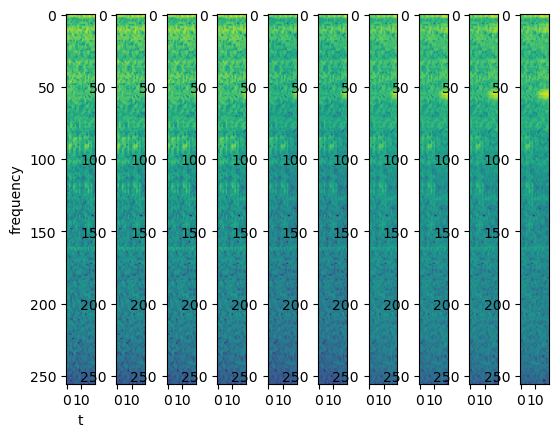

In [20]:
# for i in range(n):
#     plt.subplot(1,n,i+1)
#     plt.imshow(train_logmag_patches[0,i].T)
#     if i == 0:
#         plt.xlabel('t')
#         plt.ylabel('frequency')
# plt.show()